In [ ]:
#This Notebook has code for running CNN using 100 pixels. Uses Lasagne. Assumes that all images are in "input" folder in \
#the same directory. Also, assumes to have the two csv files - ids_train.csv and sample_submission4.csv

In [8]:
import csv
import os
import cv2
import glob
import math
import time
import random
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import lasagne
from lasagne import layers
from lasagne.layers import helper
from lasagne.updates import adam
from lasagne.nonlinearities import rectify, softmax
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, helper
from lasagne.layers import InputLayer, MaxPool2DLayer, DenseLayer, DropoutLayer, helper
from lasagne.layers import Conv2DLayer


#try:
#    from lasagne.layers.cuda_convnet import Conv2DLayer
#    from lasagne.layers.cuda_convnet import MaxPool2DLayer
#except ImportError:
#    Conv2DLayer = layers.Conv2DLayer
#    MaxPool2DLayer = layers.MaxPool2DLayer

import theano
from theano import tensor as T


#try:
#   theano.config.device = 'gpu'
#except:
    #pass # its already set
#theano.config.device = 'cpu'
theano.config.floatX = 'float32'
theano.config.blas.ldflags='-LC:\\openblas -lopenblas'

In [3]:
'''
Loading data functions
'''
PIXELS = 100
imageSize = PIXELS * PIXELS
num_features = imageSize 

def load_train_cv(encoder):
    X_train = []
    y_train = []
    print('Read train images')
    with open('id_train.csv', 'rb') as csvfile:
        trainreader = csv.reader(csvfile, delimiter=',')
        next(trainreader)
        for row in trainreader:
            file_name = os.path.join('input', row[0] + '.jpg')
            img = cv2.imread(file_name,0)
            img = cv2.resize(img, (PIXELS, PIXELS))
            #img = img.transpose(2, 0, 1)
            img = np.reshape(img, (1, num_features))
            X_train.append(img)
            y_train.append(row[1])

    X_train = np.array(X_train)
    y_train = np.array(y_train)#.astype('int32')

    y_train = encoder.fit_transform(y_train).astype('int32')

    X_train, y_train = shuffle(X_train, y_train)

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

    X_train = X_train.reshape(X_train.shape[0], 1, PIXELS, PIXELS).astype('float32') / 255.
    X_test = X_test.reshape(X_test.shape[0], 1, PIXELS, PIXELS).astype('float32') / 255.

    return X_train, y_train, X_test, y_test, encoder

def load_test():
    print('Read test images')
    X_test = []
    X_test_id = []
    with open('sample_submission4.csv', 'rb') as csvfile:
        testreader = csv.reader(csvfile, delimiter=',')
        next(testreader)
        for row in testreader:
            file_name = os.path.join('input', row[0] + '.jpg')
            img = cv2.imread(file_name,0)
            img = cv2.resize(img, (PIXELS, PIXELS))
            #img = img.transpose(2, 0, 1)
            img = np.reshape(img, (1, num_features))
            X_test.append(img)
            X_test_id.append(row[0])

    X_test = np.array(X_test)
    X_test_id = np.array(X_test_id)

    X_test = X_test.reshape(X_test.shape[0], 1, PIXELS, PIXELS).astype('float32') / 255.

    return X_test, X_test_id

In [4]:
'''
load training data and test data 
'''
encoder = LabelEncoder()

# load the training and validation data sets
train_X, train_y, valid_X, valid_y, encoder = load_train_cv(encoder)
print('Train shape:', train_X.shape, 'Dev (valid) shape:', valid_X.shape)
print('Train shape:', train_y.shape, 'Dev (valid) shape:', valid_y.shape)

# load data
X_test, X_test_id = load_test()
print('Test shape:', X_test.shape, 'Test ID shape:', X_test_id.shape)

Read train images
('Train shape:', (6400L, 1L, 100L, 100L), 'Dev (valid) shape:', (1600L, 1L, 100L, 100L))
('Train shape:', (6400L,), 'Dev (valid) shape:', (1600L,))
Read test images
('Test shape:', (13999L, 1L, 100L, 100L), 'Test ID shape:', (13999L,))


In [ ]:
from os import listdir

def load_unlabeled():
    print('Read unlabel images')
    X_unlabel = []
    X_unlabel_id = []
    train_test_list = []
    
    #get test id's
    with open('sample_submission4.csv', 'rb') as csvfile:
        testreader = csv.reader(csvfile, delimiter=',')
        next(testreader)
        for row in testreader:
            train_test_list.append(row[0]+".jpg")
    #get train ids
    with open('id_train.csv', 'rb') as csvfile:
        trainreader = csv.reader(csvfile, delimiter=',')
        next(trainreader)
        for row in trainreader:
            train_test_list.append(row[0]+".jpg")
    
    #file_names = os.path.join('input', '*.jpg')
    all_files = listdir('input')
    for i in range(0,len(all_files)):
        if all_files[i] not in train_test_list:
            #print all_files[i]
            img = cv2.imread(os.path.join('input', all_files[i]),0)
            img = cv2.resize(img, (PIXELS, PIXELS))
            #img = img.transpose(2, 0, 1)
            img = np.reshape(img, (1, num_features))
            X_unlabel.append(img)
            X_unlabel_id.append(row[0])

    X_unlabel = np.array(X_unlabel)
    X_unlabel_id = np.array(X_unlabel_id)

    X_unlabel = X_unlabel.reshape(X_unlabel.shape[0], 1, PIXELS, PIXELS).astype('float32') / 255.

    return X_unlabel, X_unlabel_id

# load unlabeled data
X_unlabel, X_unlabel_id = load_unlabeled()
print('unlabeled shape:', X_unlabel.shape, 'unlabeled ID shape:', X_unlabel_id.shape)

[[   0 2741]
 [   1 1514]
 [   2  671]
 [   3 1474]]


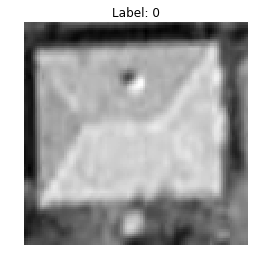

In [5]:
# Plot an example image with its label
#print train_X[:1]
unique, counts = np.unique(train_y, return_counts=True)
print np.asarray((unique, counts)).T

plt.imshow(train_X[527][0], interpolation='nearest', cmap=plt.cm.gray)
plt.title("Label: {}".format(train_y[527]))
plt.gca().set_axis_off()
#plt.show()

In [9]:

'''
Lasagne Model ZFTurboNet and Batch Iterator
'''
def ZFTurboNet(input_var=None):
    l_in = InputLayer(shape=(None, 1, PIXELS, PIXELS), input_var=input_var)

    l_conv = Conv2DLayer(l_in, num_filters=8, filter_size=(3,3), pad=1, nonlinearity=rectify)
    l_pool1 = MaxPool2DLayer(l_conv, pool_size=2) # feature maps 12x12
    l_convb = Conv2DLayer(l_pool1, num_filters=8, filter_size=(3,3), pad=1, nonlinearity=rectify)
    l_pool2 = MaxPool2DLayer(l_convb, pool_size=2) # feature maps 12x12

    l_dropout1 = DropoutLayer(l_pool2, p=0.25)
    l_hidden = DenseLayer(l_dropout1, num_units=128, nonlinearity=rectify)
    l_dropout2 = DropoutLayer(l_hidden, p=0.5)

    l_out = DenseLayer(l_dropout2, # The number of units in the softmas output layer is the number of classes.
                       num_units=4, nonlinearity=softmax)

    return l_out

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]



In [10]:
"""
Set up all theano functions
"""
BATCHSIZE = 5
LR = 0.001
ITERS = 10

theano.config.optimizer = 'None'

X = T.tensor4('X')
Y = T.ivector('y')

# set up theano functions to generate output by feeding data through network, any test outputs should be deterministic
output_layer = ZFTurboNet(X)
output_train = lasagne.layers.get_output(output_layer)
output_test = lasagne.layers.get_output(output_layer, deterministic=True)

# set up the loss that we aim to minimize, when using cat cross entropy our Y should be ints not one-hot
loss = lasagne.objectives.categorical_crossentropy(output_train, Y)
loss = loss.mean()

# set up loss functions for validation dataset
valid_loss = lasagne.objectives.categorical_crossentropy(output_test, Y)
valid_loss = valid_loss.mean()

valid_acc = T.mean(T.eq(T.argmax(output_test, axis=1), Y), dtype=theano.config.floatX)

# get parameters from network and set up sgd with nesterov momentum to update parameters
params = lasagne.layers.get_all_params(output_layer, trainable=True)
updates = adam(loss, params, learning_rate=LR)

# set up training and prediction functions
train_fn = theano.function(inputs=[X,Y], outputs=loss, updates=updates)
valid_fn = theano.function(inputs=[X,Y], outputs=[valid_loss, valid_acc])

# set up prediction function
predict_proba = theano.function(inputs=[X], outputs=output_test)


In [13]:
'''
start training
'''

# loop over training functions for however many iterations, print information while training
try:
    for epoch in range(ITERS):
        # do the training
        start = time.time()
        # training batches
        train_loss = []
        for batch in iterate_minibatches(train_X, train_y, BATCHSIZE):
            inputs, targets = batch
            train_loss.append(train_fn(inputs, targets))
        train_loss = np.mean(train_loss)
        # validation batches
        valid_loss = []
        valid_acc = []
        for batch in iterate_minibatches(valid_X, valid_y, BATCHSIZE):
            inputs, targets = batch
            valid_eval = valid_fn(inputs, targets)
            valid_loss.append(valid_eval[0])
            valid_acc.append(valid_eval[1])
        valid_loss = np.mean(valid_loss)
        valid_acc = np.mean(valid_acc)
        # get ratio of TL to VL
        ratio = train_loss / valid_loss
        end = time.time() - start
        # print training details
        print('iter:', epoch, '| TL:', np.round(train_loss,decimals=3), '| VL:', np.round(valid_loss, decimals=3), \
              '| Vacc:', np.round(valid_acc, decimals=3), '| Ratio:', np.round(ratio, decimals=2), '| Time:', \
              np.round(end, decimals=1))

except KeyboardInterrupt:
    pass

In [12]:
'''
Make Submission
'''

#make predictions
print('Making predictions')
PRED_BATCH = 1
def iterate_pred_minibatches(inputs, batchsize):
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

predictions = []
for pred_batch in iterate_pred_minibatches(X_unlabel, PRED_BATCH):
    predictions.extend(predict_proba(pred_batch))


predictions = np.array(predictions)
print('pred shape')
print(predictions.shape)

with open('CNN_unlabeled.csv', 'wb') as mycsvfile:
            thedatawriter = csv.writer(mycsvfile)
            thedatawriter.writerow(['Id','label'])
            for i in range(predictions.shape[0]):
                out = [X_unlabel_id[i],predictions[i].argmax(0)+1]
                thedatawriter.writerow(out)

Making predictions
pred shape
(13999L, 4L)
